Developer: Brady Lange

Date: 04/15/2020

Course: CSIS 452

Description: Beijing particle pollution analysis.

In [1]:
# Import required libraries
import os
import pickle
from six.moves import urllib
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
DATASETS_ROOT = "http://archive.ics.uci.edu/ml/machine-learning-databases/"
PM2_5_PATH = os.path.join("datasets", "pm2_5")
FILE = "PRSA_data_2010.1.1-2014.12.31.csv"
PM2_5_URL = DATASETS_ROOT + "00381/" + FILE

In [3]:
def fetch_dataset(dataset_url, dataset_path, file_name):
    '''
    
    '''
    if not os.path.isdir(dataset_path):
        os.makedirs(dataset_path)
    
    file_path = os.path.join(dataset_path, file_name)
    
    if os.path.exists(file_path):
        return None
        
    local_file_name, headers = urllib.request.urlretrieve(dataset_url, file_path)
    dataset_file = open(local_file_name)
    dataset_file.close()
    
def load_dataset(dataset_path, file_name):
    file_path = os.path.join(dataset_path, file_name)
    file = pd.read_csv(file_path)
    return file

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, df):
        return df[self.attribute_names].values
    
    
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_snow_rain_sum = False, ls_idx = 8, lr_idx = 9):
        self.add_snow_rain_sum = add_snow_rain_sum
        self.ls_idx = ls_idx
        self.lr_idx = lr_idx
        
    def fit(self, X, y = None):
        return self
        
    def transform(self, df):
        if self.add_snow_rain_sum is True:
            snow_rain_sum = (df[:, self.ls_idx] + df[:, self.lr_idx]).reshape(-1, 1)
            return np.hstack([df, snow_rain_sum])
        else:
            return df

   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0 

          No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd     Iws  \
43819  43820  2014     12   31    19    8.0   -23  -2.0  1034.0   NW  231.97   
43820  43821  2014     12   31    20   10.0   -22  -3.0  1034.0   NW  237.78   
43821  43822  2014     12   31    21   10.0   -22  -3.0  1034.0   NW  242.70   
43822  43823  2014     12   31    22    8.0   -22  -4.0  1034.0   NW  246.72   
43823  43824  2014     12   31    23   12.0   -21  -3.0  1034.0   NW  249.85   

       Is  Ir  
43819   0   0  
43820   0   0  
43821  

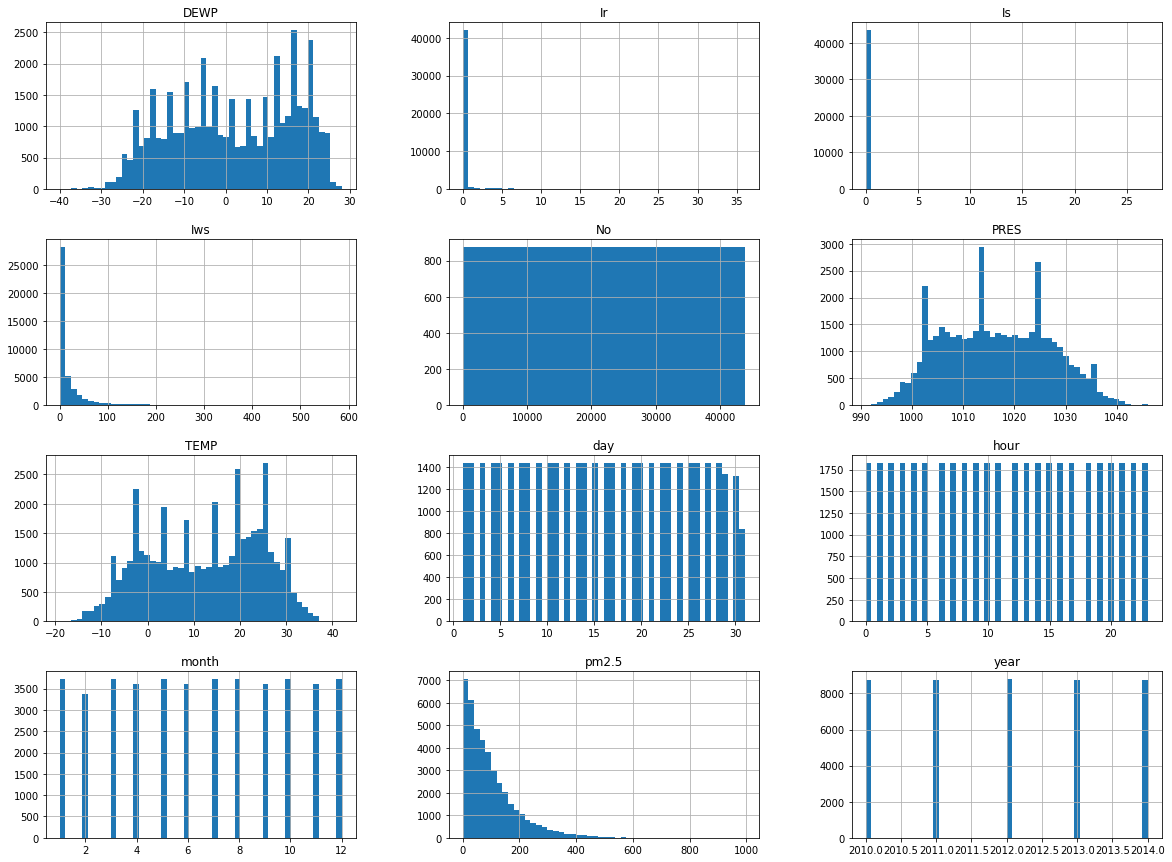

In [4]:
# Fetch PM2.5 dataset and download it locally
fetch_dataset(PM2_5_URL, PM2_5_PATH, FILE)

# Load PM2.5 dataset
pm2_5 = load_dataset(PM2_5_PATH, FILE)

print(pm2_5.head(), "\n")
print(pm2_5.tail(), "\n")
print(pm2_5.info(), "\n")
print(pm2_5.describe(), "\n")
print(pm2_5.count(), "\n")
print(pm2_5.isnull().sum(), "\n")
print(pm2_5["year"].value_counts(), "\n")
print(pm2_5["cbwd"].value_counts(), "\n")
pm2_5.hist(bins = 50, figsize = (20, 15))
plt.show()

In [5]:
# Remove unnecessary features
pm2_5_clean = pm2_5.drop(["No", "year"], axis = 1)

pm2_5_clean = pm2_5_clean.dropna(subset = ["pm2.5"])
print(pm2_5_clean.isnull().sum(), "\n")

col_idx = [pm2_5.columns.get_loc(col) for col in pm2_5]

num_feat_names = pm2_5_clean.drop(["cbwd"], axis = 1).columns
cat_feat_names = pm2_5_clean[["cbwd"]].columns
target_names = pm2_5_clean[["pm2.5"]].columns

num_pipeline = Pipeline(
    steps = [
        ("selector", DataFrameSelector(num_feat_names)),
        ("mean_imputer", SimpleImputer(strategy = "mean")),
        ("attributes_adder", CombinedAttributesAdder(add_snow_rain_sum = True)),
        ("std_scaler", StandardScaler())
    ]
)

cat_pipeline = Pipeline(
    steps = [
        ("selector", DataFrameSelector(cat_feat_names)),
        ("one_hot_encoder", OneHotEncoder(sparse = False))
    ]
)

ml_pipeline = FeatureUnion(
    transformer_list = [
        ("numeric_pipeline", num_pipeline),
        ("categoric_pipeline", cat_pipeline)
    ]
)

pm2_5_clean = ml_pipeline.fit_transform(pm2_5_clean)
print(pm2_5_clean.dtype.names)

train, test = train_test_split(pm2_5_clean, test_size = 0.2, shuffle = True, random_state = 10)
print(train.shape, test.shape)

# Serialize the training and testing sets
pm2_5_pickle_path = os.path.join(PM2_5_PATH, "PRSA_data_2010.1.1-2014.12.31.pickle")
with open(pm2_5_pickle_path, "wb") as f:
    pickle.dump([train, test], f)

# Remove target variable
X_train = np.delete(train, 3, axis = 1)
y_train = train[:, 3]
X_test = np.delete(test, 3, axis = 1)
y_test = test[:, 3]
print(X_train.shape, "\n")
print(y_train.shape, "\n")
print(X_test.shape, "\n")
print(y_test.shape, "\n")

month    0
day      0
hour     0
pm2.5    0
DEWP     0
TEMP     0
PRES     0
cbwd     0
Iws      0
Is       0
Ir       0
dtype: int64 

None
(33405, 15) (8352, 15)
(33405, 14) 

(33405,) 

(8352, 14) 

(8352,) 



In [6]:
# Linear Regression
linear_reg = LinearRegression()
print("Linear Regression model has started training...")
# Compute Linear Regression 10-fold cross-validation score
linear_scores = cross_val_score(
    linear_reg, 
    X_train, 
    y_train, 
    scoring = "neg_mean_squared_error", 
    cv = 10
)
print("Linear Regression model has finished training...")

# Polynomial features
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_train_poly = poly_features.fit_transform(X_train)

# Elastic Net Regression
elastic_net_reg = ElasticNet(alpha = 0.1, l1_ratio = 0.5, max_iter = 1000, random_state = 10)
print("Elastic Net Regression model has started training...")
# Compute Elastic Net Regression 10-fold cross-validation score
elastic_net_scores = cross_val_score(
    elastic_net_reg, 
    X_train_poly, 
    y_train, 
    scoring = "neg_mean_squared_error", 
    cv = 10
)
print("Elastic Net Regression model has finished training...")

# Decision Tree Regression
tree_reg = DecisionTreeRegressor(random_state = 10)
print("Decision Tree Regression model has started training...")
# Compute Decision Tree Regression 10-fold cross-validation score
tree_scores = cross_val_score(
    tree_reg, 
    X_train, 
    y_train, 
    scoring = "neg_mean_squared_error", 
    cv = 10
)
print("Decision Tree Regression model has finished training...")

# Random Forest Regression
forest_reg = RandomForestRegressor(n_jobs = -1, random_state = 10)
print("Random Forest Regression model has started training...")
# Compute Random Forest Regression 10-fold cross-validation score
forest_scores = cross_val_score(
    forest_reg, 
    X_train, 
    y_train, 
    scoring = "neg_mean_squared_error", 
    cv = 10
)
print("Random Forest Regression model has finished training...")

# Support Vector Regression
supp_vec_reg = SVR()
print("Support Vector Regression model has started training...")
# Compute Random Forest Regression 10-fold cross-validation score
supp_vec_scores = cross_val_score(
    supp_vec_reg, 
    X_train, 
    y_train, 
    scoring = "neg_mean_squared_error", 
    cv = 10
)
print("Support Vector Regression model has finished training...")

# Gradient Boosting Regression
grad_boost_reg = GradientBoostingRegressor(random_state = 10)
print("Gradient Boosting Regression model has started training...")
# Compute Gradient Boosting Regression 10-fold cross-validation score
grad_boost_scores = cross_val_score(
    grad_boost_reg, 
    X_train, 
    y_train, 
    scoring = "neg_mean_squared_error", 
    cv = 10
)
print("Gradient Boosting Regression model has finished training...")

Linear Regression model has started training...
Linear Regression model has finished training...
Elastic Net Regression model has started training...
Elastic Net Regression model has finished training...
Decision Tree Regression model has started training...
Decision Tree Regression model has finished training...
Random Forest Regression model has started training...


C:\Users\brady\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\brady\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\brady\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\brady\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\brady\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Random Forest Regression model has finished training...
Support Vector Regression model has started training...


C:\Users\brady\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\brady\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\brady\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\brady\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

Support Vector Regression model has finished training...
Gradient Boosting Regression model has started training...
Gradient Boosting Regression model has finished training...


['7.85%', '8.02%', '5.83%', '4.42%', '6.49%', '6.38%']


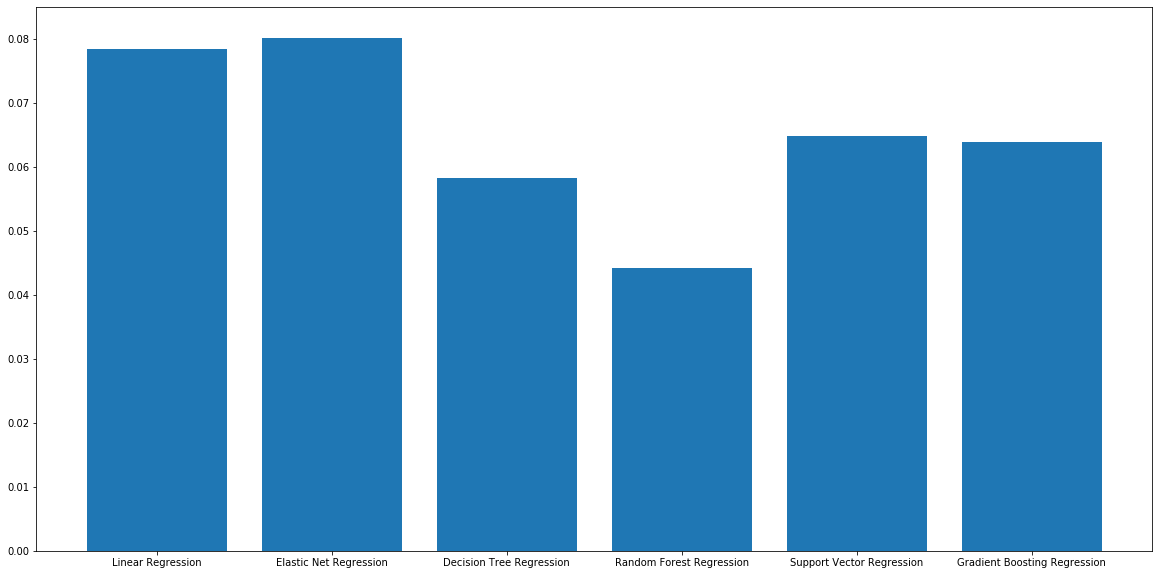

In [7]:
# Model selection
target_range = y_train.max() - y_train.min()
linear_avg_rmse = np.sqrt(-linear_scores).mean() / target_range
elastic_net_avg_rmse = np.sqrt(-elastic_net_scores).mean() / target_range
tree_avg_rmse = np.sqrt(-tree_scores).mean() / target_range
forest_avg_rmse = np.sqrt(-forest_scores).mean() / target_range
supp_vec_avg_rmse = np.sqrt(-supp_vec_scores).mean() / target_range
grad_boost_avg_rmse = np.sqrt(-grad_boost_scores).mean() / target_range

model_names = ["Linear Regression", "Elastic Net Regression", "Decision Tree Regression", 
               "Random Forest Regression", "Support Vector Regression", 
               "Gradient Boosting Regression"]
avg_rmses = np.array([linear_avg_rmse, elastic_net_avg_rmse, tree_avg_rmse, 
                      forest_avg_rmse, supp_vec_avg_rmse, grad_boost_avg_rmse])
print(["{:0.2%}".format(item) for item in np.squeeze(avg_rmses)])

plt.figure(figsize = (20, 10))
plt.bar(x = [item for item in range(1, avg_rmses.shape[0] + 1)], height = np.squeeze(avg_rmses))
plt.xticks([item for item in range(1, avg_rmses.shape[0] + 1)], model_names)
plt.ylim(ymax = 0.085)
plt.show()

In [8]:
# Fine tuning the model - robust for when search space is small
param_grid = [{"n_estimators": [10, 50, 200]}, {"min_samples_leaf": [1, 10, 100]}]
grid_search = GridSearchCV(forest_reg, param_grid, cv = 10, scoring = "neg_mean_squared_error", n_jobs = -1)
grid_search.fit(X_train, y_train.squeeze())
print(grid_search.best_params_)

# Evaluation scores
print(np.sqrt(-grid_search.cv_results_["mean_test_score"]))

# Parameters
print(grid_search.cv_results_["params"])
cv_res = grid_search.cv_results_
for params, mean_score in zip(cv_res["params"], cv_res["mean_test_score"]):
    print(params, "==>", np.sqrt(-mean_score))
    
# RMSE
forest_rmse_scores = np.sqrt(-grid_search.cv_results_["mean_test_score"])
print("RMSE:\n", forest_rmse_scores)
avg_cross_val_forest_rmse = forest_rmse_scores.mean()
print("Average Cross-Validation RMSE:\n", avg_cross_val_forest_rmse)

{'n_estimators': 200}
[0.47799874 0.44801119 0.44332768 0.47799874 0.54597113 0.68177441]
[{'n_estimators': 10}, {'n_estimators': 50}, {'n_estimators': 200}, {'min_samples_leaf': 1}, {'min_samples_leaf': 10}, {'min_samples_leaf': 100}]
{'n_estimators': 10} ==> 0.47799874179738583
{'n_estimators': 50} ==> 0.4480111917363607
{'n_estimators': 200} ==> 0.44332768393622674
{'min_samples_leaf': 1} ==> 0.4779987417973859
{'min_samples_leaf': 10} ==> 0.5459711312154238
{'min_samples_leaf': 100} ==> 0.68177440668
RMSE:
 [0.47799874 0.44801119 0.44332768 0.47799874 0.54597113 0.68177441]
Average Cross-Validation RMSE:
 0.5125136495271305


In [9]:
# Best Random Forest Regression
best_forest_reg = grid_search.best_estimator_
print("Random Forest Regression model has started training...")
# Compute Random Forest Regression 10-fold cross-validation score
best_forest_scores = cross_val_score(
    best_forest_reg, 
    X_train, 
    y_train, 
    scoring = "neg_mean_squared_error", 
    cv = 10
)
print("Random Forest Regression model has finished training...")

# RMSE
best_forest_rmse_scores = np.sqrt(-best_forest_scores)
print("RMSE:\n", str(best_forest_rmse_scores)[1:-1])
avg_cross_val_best_forest_rmse = best_forest_rmse_scores.mean()
print("Average Cross-Validation RMSE:\n", avg_cross_val_best_forest_rmse)

# RMSE normalized
best_forest_avg_rmse = np.sqrt(-best_forest_scores).mean() / target_range
print("RMSE Normalized:\n {:0.2%}".format(best_forest_avg_rmse))

# Predict new data
h_test = best_forest_reg.predict(X_test)
test_mse = mean_squared_error(y_test, h_test)
test_rmse = np.sqrt(test_mse) / target_range
print("Test RMSE:\n {:0.2%}".format(test_rmse))

Random Forest Regression model has started training...
Random Forest Regression model has finished training...
RMSE:
 0.43182821 0.46478465 0.4325805  0.45126238 0.42601877 0.43021563
 0.43494122 0.47551788 0.43827816 0.44517005
Average Cross-Validation RMSE:
 0.4430597465347067
RMSE Normalized:
 4.10%
Test RMSE:
 3.99%
